In [6]:
import torch
import numpy
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [7]:
n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim,
                              centers=[[0,0],[1,1],[1,0],[0,1]],
                              shuffle=True, cluster_std=0.15)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                            centers=[[0,0],[1,1],[1,0],[0,1]],
                            shuffle=True, cluster_std=0.15)

In [8]:
for i, x in enumerate(x_train):
    print(x, y_train[i])
    if i == 15 : break

[0.99510223 0.9922192 ] 1
[0.95911622 0.95269331] 1
[1.02972639 1.31164002] 1
[-0.00788657  0.02529465] 0
[0.9100533  0.76785141] 1
[0.05015618 0.03379258] 0
[0.6672083  0.05485802] 2
[0.2623025  0.84878382] 3
[ 0.14702479 -0.14902363] 0
[0.58732112 1.14668313] 1
[0.75108366 0.01580509] 2
[0.07327825 1.09035451] 3
[ 0.0150603  -0.19830949] 0
[0.9937026  0.01710078] 2
[0.82006521 0.07423249] 2
[0.02981896 0.01178186] 0


label을 재설정해주겠습니다. 저희는 Binary Classify를 하기위한 NN을 만들려고 하거든요

In [9]:
def label_map(y_, from_, to_):
    y = numpy.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

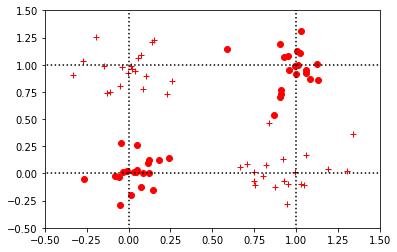

In [10]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.plot([-1, 2], [0,0], linestyle = ":", color = 'k')
plt.plot([-1, 2], [1,1], linestyle = ":", color = 'k')
plt.plot([0, 0], [-1, 2], linestyle = ":", color = 'k')
plt.plot([1, 1], [-1,2], linestyle = ":", color = 'k')
#vis_data(x_test, y_test, c='b')
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

In [11]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])


layer 는 여러 노드들이 층으로 모여있는 것을 의미하는데요
여기에는 

In [12]:
class NeuralNet(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            
            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.linear_2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
            
        def forward(self, input_tensor):
            linear1 = self.linear_1(input_tensor)
            relu = self.relu(linear1)
            
            linear2 = self.linear_2(relu)
            output = self.sigmoid(linear2)
            return output

criterion 은 에러함수를 의미합니다.
교수님께서 아까도 설명하셨지만 지금과같은 B Classify할때는 MSE를 사용하는 것이 적당하지 않습니다. 그래서 저희는 Binary Cross Entropy 를 사용할것인데 이것도 torch에서 제공하고 있습니다.

왜 (2,5)로 했을까?

In [20]:
model = NeuralNet(2, 5)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [29]:
model(torch.tensor([0.1,0.1]))

tensor([0.3438], grad_fn=<SigmoidBackward>)

model의 weight가 어떻게 존재할까요

In [21]:
for a in model.parameters():
    print(a)

Parameter containing:
tensor([[-0.4962,  0.2236],
        [-0.5363, -0.6905],
        [ 0.0311, -0.4017],
        [-0.6776,  0.4502],
        [ 0.7035,  0.3716]], requires_grad=True)
Parameter containing:
tensor([ 0.0033,  0.0286,  0.5285, -0.5612,  0.5610], requires_grad=True)
Parameter containing:
tensor([[-0.2515,  0.2412,  0.0887,  0.2452, -0.4329]], requires_grad=True)
Parameter containing:
tensor([0.3628], requires_grad=True)


In [22]:
for a in model.parameters():
    print(a.grad)

None
None
None
None


In [23]:
model.eval()
test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.7035549879074097


In [24]:
model.train()
optimizer.zero_grad()
train_output = model(x_train)
train_loss = criterion(train_output.squeeze(), y_train)
train_loss.backward()
optimizer.step()

In [25]:
learning_rate = 0.03
epochs = 2000

In [26]:
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
        torch.save(model.state_dict(), './model_epoch{}.pt'.format(epoch))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.7023493051528931
Train loss at 100 is 0.6960718631744385
Train loss at 200 is 0.6937430500984192
Train loss at 300 is 0.6927529573440552
Train loss at 400 is 0.6892130374908447
Train loss at 500 is 0.6802937984466553
Train loss at 600 is 0.6635920405387878
Train loss at 700 is 0.6464056372642517
Train loss at 800 is 0.6294850707054138
Train loss at 900 is 0.6125720739364624
Train loss at 1000 is 0.5967759490013123
Train loss at 1100 is 0.5813840627670288
Train loss at 1200 is 0.5670108199119568
Train loss at 1300 is 0.5536561608314514
Train loss at 1400 is 0.5407253503799438
Train loss at 1500 is 0.5272702574729919
Train loss at 1600 is 0.511857807636261
Train loss at 1700 is 0.4928974509239197
Train loss at 1800 is 0.46838250756263733
Train loss at 1900 is 0.43676504492759705


In [27]:
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.3732922673225403


모델을 저장할 필요성 설명

In [ ]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[-0.0952, -0.3065],
        [-1.5758,  1.3716],
        [ 0.9289,  1.4012],
        [-1.8554, -1.5239],
        [-0.0151, -0.7519]])), ('linear_1.bias', tensor([ 0.7045, -0.0577, -1.0179,  1.5898,  1.0049])), ('linear_2.weight', tensor([[ 0.5065,  2.0090, -1.9252, -2.8284,  0.9424]])), ('linear_2.bias', tensor([0.4480]))])


저장 할수 있다면 중간중간에도 저장할 수 있을까?

In [ ]:
new_model = NeuralNet(2, 5)
new_model.load_state_dict(torch.load('./model.pt'))
new_model.eval()
print('벡터 [0, 1]이 레이블 1을 가질 확률은 {}'.format\
      (new_model(torch.FloatTensor([0,1])).item()))

벡터 [0, 1]이 레이블 1을 가질 확률은 0.9310815334320068


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round((y_pred)).squeeze()

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
new_model.eval()
print(torch.round(new_model(x_test)).squeeze())
print(y_test)
print(binary_acc(new_model(x_test), y_test))

tensor([0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 1.], grad_fn=<SqueezeBackward0>)
tensor([0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1.,
        0., 1.])
tensor(100.)


In [ ]:
for i in range(0,2000,100):
    new_model = NeuralNet(2, 5)
    new_model.load_state_dict(torch.load('./model_epoch{}.pt'.format(i)))
    new_model.eval()
    print("======epoch : {} =======".format(i))
    print(binary_acc(new_model(x_test), y_test))

======epoch : 0 =======
tensor(50.)
======epoch : 100 =======
tensor(55.)
======epoch : 200 =======
tensor(70.)
======epoch : 300 =======
tensor(75.)
======epoch : 400 =======
tensor(75.)
======epoch : 500 =======
tensor(75.)
======epoch : 600 =======
tensor(75.)
======epoch : 700 =======
tensor(80.)
======epoch : 800 =======
tensor(90.)
======epoch : 900 =======
tensor(100.)
======epoch : 1000 =======
tensor(100.)
======epoch : 1100 =======
tensor(100.)
======epoch : 1200 =======
tensor(100.)
======epoch : 1300 =======
tensor(100.)
======epoch : 1400 =======
tensor(100.)
======epoch : 1500 =======
tensor(100.)
======epoch : 1600 =======
tensor(100.)
======epoch : 1700 =======
tensor(100.)
======epoch : 1800 =======
tensor(100.)
======epoch : 1900 =======
tensor(100.)
